In [1]:
# to suppress futurewarnings caused by pandas and other libraries not updating their numpy interface codes
# apparently has to come before these import, so leave this on top
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import string
import theano

import functools

import therapy

sns.set()
plt.ion()

# 6 Overfitting, Regularization, and Information Criteria

**Ockham's Razor** making aesthetic/pragmatic preference for simpler model more explicit: prefer models w/ fewer assumptions. For same performance, choose simpler model. But what to do for different trade-offs in terms of simplicity vs accuracy? Content of this chapter.

Fundamental trade-off between **overfitting**, poor prediction by learning too much, and **underfitting**, poor prediction by learning too little. Need to navigate space in-between.

Methods to tackle: 

* **regularizing prior**, same as penalized likelihood in frequentist term, learn less from data
* **infromation criteria** to score models

**rethinking: stargazing.** common method of model selection: pick model with highest number of significant coefficients. but: p-values not designed to make under-/overfitting trade-off. helpful coeff. can be non-significant, significant coeff. can be unhelpful.

**rethinking: is aic bayesian?** not originally derived and often not seen as such, but can be interpreted as special limit of bayes. criterion like WAIC. example of common phenomenon in stats: same procedure can be dried and justified from multiple, sometimes philosophically incompatible perspectives.

## 6.1. the problem with parameters

Previous chapter: adding parameters can be helpful by revealing hidding effects. also, adding parameters can hurt if parameters are highly correlated. how about case of adding non-highly-correlated parameters? also not always safe.

two main problems:

* adding parameters nearly always makes model fit better, i.e. reduces train error. McElreath mentions $R^2$ or 'variance explained' metric. Increased for more predictor variables, even if they are random numbers. **understand 'variance explained', intuitive meaning unclear**
* more complex models often have better fit, but worse predictions on unseen data = overfit! but simple models tend to underfit. no simple answer, need to make trade-off.

### 6.1.1. more parameters always improve fit

Overfitting = learning too much from data

* regular features: useful, generalize well or inform about quesiton of interest
* irrregular features: misguiding, aspects of data that do not generalize

In [4]:
# Code 6.1

data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data).set_index('species')
d

,brain,mass
species,,
afarensis,438,37.0
africanus,452,35.5
habilis,612,34.5
boisei,521,41.5
rudolfensis,752,55.5
ergaster,871,61.0
sapiens,1350,53.5


Q: assuming that brain size is generally correlated w/ body mass, which species have unexpectedly large brains for their body mass?

Common strategy: 'statistical control'. Fit lin. reg. between those two vars. Residuals of predicting brain vol from body mass = unexplained variance = come from other factors = unexpectedly high/low.

But: why lin. reg.? Why line? Might be some curve relating body mass to brain vol. Why not use residuals of that regression? That could be how things are in nature.

Fit increasingly complex models, observe fit.

In [5]:
# Code 6.2

m_6_1 = smf.ols('brain ~ mass', data=d).fit()

inspect $R^2$ of model. variance 'explained' by model = lin model predicts some variation of training data. remaining variation = variation of residuals

In [6]:
# Code 6.3

1 - m_6_1.resid.var() / d.brain.var()

0.490158047949084

In [7]:
# my own comparison: 
m_6_1.rsquared

0.490158047949084

In [8]:
m_6_1.summary()

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  brain   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Fri, 21 Jun 2019   Prob (F-statistic):             0.0798
Time:                        16:13:52   Log-Likelihood:                -47.462
No. Observations:                   7   AIC:                             98.92
Df Residuals:                       5   BIC:                             98.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -227.6287    439.794     -0.518      0.627   -1358.154     902.897
mass          20.6889      9.436      2.192      0.080      -3.568      44.946
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         215.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# Code 6.4

m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

In [10]:
# Code 6.5

m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

higher degree of polynomial = better fit, until 0 residuals for 6th degree, $R^2 = 1$

however: absurd model. curve follows all data points, but pays no price for absurd predictions like negative brain mass in areas without dat

reason: n params = n data points. use unique parameter to remember each datum.

**rethinking: model fitting as compression.** model fitting can be seen as data compression. parameters = summarize relationship among data in lossy way. use params to generate new data = decompress. if n params == n data points then no compression, just encoding in different way. consequence: learn nothing. need to use simpler model, but not too simpel. known as minimum description length.

### 6.1.2. too few parameters hurs, too

overfitting: low train error, high test error

underfitting: high train and test error. learned too little.

In [11]:
# Code 6.6

m_6_7 = smf.ols('brain ~ 1', data=d).fit()

estimate mean brain volume without considering brain mass = regression is horizontal line with wide confidence region. bad for seen and unseen data

underfit model = under-sensitive to data, changes too little based on seen data (inflexible)
overfit model = over-sensitive to data, changes too much based on seen data (volatile)

**overthinking: dropping rows.**

In [1]:
# Code 6.7

d_new = d.drop(d.index[0])

NameError: name 'd' is not defined

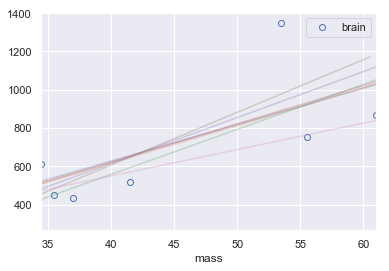

In [13]:
# Code 6.8
ax = d.plot.line(x='mass', y='brain', style=['ob'], fillstyle='none', mew=1)

for i in range(d.index.size):
    d_new = d.drop(d.index[i])

    m_0 = smf.ols('brain ~ mass', data=d_new).fit()

    x_pred = np.linspace(d_new.mass.min() -5, d_new.mass.max() + 5, 50)
    y_pred = m_0.params.Intercept + m_0.params.mass * x_pred

    ax.plot(x_pred, y_pred, alpha=.3);

**rethinking: bias and variance.** underfitting/overfitting also caused bias problems / variance problems. confusing nomenclature as these terms heavily overloaded in different contexts. also, increasing bias can improve predictions for unseen data.

## 6.2. information theory and model performance

Define what model needs to do well at: target. Proposed here: out-of-sample deviance

### 6.2.1. firing the weatherperson

Define target needs at least:

* cost-benefit. cost of wrong prediction, value of correct prediction
* performance in context. how good could a model be for this task?

#### 6.1.1.1. costs and benefits

different decision about better model for different cost/benefit analysis

#### 6.1.1.2. measuring accuracy

even if ignoring cost/benefit unclear which measure of accuracy to use. 

McElreath: joint probability is correct measure. reason: currectly counts up relative nr of ways each event could happen = likelihood in B's theorem. **revisit likelihood, model definition, model structure of earlier chapters**

"maximizing joint probability will identify right model" **what does right model mean?**

how to measure performance? should account for difficulty of task. ex: if adding more categories, task becomes harder.

**rethinking: what is a true model?** real world = deterministic. if all info was known, predictions would not be probabilities but just 1/0 for rain vs sunshine. but: we are ignorant of some information. 'right' = correct probabilities given our state of ignorance. "probability is in the model, not in the world". **but then, is each model a true model given its own assumptions of ignorance? unclear, discuss.**

### 6.2.2. information theory and uncertainty

information = reduction in uncertainty through learning an outcome

define: f(probability of rain) -> uncertainty

measure of uncertainty should be 

* continuous
* increasing for more events
* additive

exactly one f() satisfying all criteria: information entropy.

$$
H(p) = -E \log (p_i) = - \sum_{i=1}^n p_i \log (p_i)
$$

read: "uncertainty in a probability distribution is the average log-probability of an event"

McElreath does not explain derivation, but points out: all parts of definition are there for a reason, to satisfy requirements listed above. However, above all, information entropy being used b/c it's proven to be very productive and useful.

ex. on page illustrates: entropy of weather for Abu Dhabi much lower, as weather very uniform, thus low uncertainty. If adding 'snow' as weather condition: entropy/uncertainty increases.

code for calculating entropy for one example:

In [14]:
## Code 6.9

p = np.array([0.3, 0.7])
- np.sum((p * np.log(p)))

0.6108643020548935

**overthinking: more on entropy.** 
* "-1" in definition above customary but not necessary. leads to entropy increase from zero instead of decrease from one. 
* base of logarithm arbitrary, as long as same based used for all comparisons
* how to deal with 0-probabilty events? drop out. assume that $0 \log(0) = 0$. "not a trick but not obvious". remember: no sense to keep event that never happens in model.

**rethinking: the benefits of maximizing uncertainty** maximum entropy (maxent) = family of techniques for finding prob. distr. most consistent w/ current knowledge. given current knowledge, what distr. is least surprising? will be used to build GLMs later.

### 6.2.3. from entropy to accuracy

**discuss: entropy is way of quantifying uncertainty. but why is that necessary? already had probabilities around parameters to quantifiy uncertainty?**

How to use info entropy to measure model perf in distance from optimum? Divergence!

Divergence = "the additional uncertainty induced by using probabilities from one distribution to describe another distribution" = Kullback-Leibler divergence = K-L divergence

divergence(p,q) = KL(p,q) = "average difference in log proability between target p and model q"

difference of entropies: "entropy of target p and cross entropy of using q to predict p"

true probabilities = p
approximation = q

KL(p,q) = 0 iff p = q
KL(p,q) > 0 otherwise

grows the more q is different from p

**overthinking: cross entropy and divergence.** cross entropy: events arise according to p, but are expected according to q, inflating uncertainty. 

$$H(p,q) = - \sum_i p_i \log(q_i)$$ 

Divergence = additional uncertainty due to cross entropy, thus 

$$KL(p,q) = H(p,q) - H(p)$$

**rethinking: divergence depends upon direction.** my intuition: high entropy distribution = lots of ignorance = don't know what to expect, no event much more likely than others. use this to predict other distribution means we won't be super surprised by any outcome. 

flip side: low entropy distribution = lots of expectations = some events are much more likely than others. if we use low entropy distribution to predict other distribution and they don't match well: very surprised by outcome, high divergence. outcome has high information value?

### 6.2.4. from divergence to deviance
Know how to measure distance from true probability distr. $p$. But how to use in practice when $p$ is unknown? (wouldn't need to find model otherwise)

Solution: don't know distance from $p$, but can know whether $q$ or $r$ is relatively closer. Deviance as relative measure.

Summing log probabilities for each observed case gives approx of $E\log(q_i)$

Don't need to know $p$ in expectation term "because nature takes care of presenting the events to us". **what does that mean?**

absolute magnitude of deviance not meaningful, only difference between models is

deviance = 

$$
D(q) = -2 \sum_i \log(q_i)
$$

$i$ = case index, $q_i$ = likelihood of case $i$. divergence scales w/ sample size.

calc deviance by computing log-prop of observed data given MAP param estimates

In [15]:
# Code 6.10

m_6_1 = smf.ols('brain ~ mass', data=d).fit()

-2 * m_6_1.llf

94.92498968588757

uncertainty about params -> uncertainty about deviance. for fixed set of params deviance also fixed

**overthinking: computing deviance.**

In [16]:
# Code 6.11
d['mass_s'] = (d.mass - d.mass.mean()) / d.mass.std()

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    
    # why '*10'?
    sigma = pm.Uniform('sigma', 0, np.std(d['brain']) * 10)
    
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    
    m_6_8 = pm.sample(2000, tune=5000)

theta = pm.summary(m_6_8).loc[['a', 'b', 'sigma'], 'mean']
theta

dev = -2 * np.sum(stats.norm.logpdf(
    x = d['brain'], 
    loc = theta['a'] + theta['b'] * d['mass_s'], 
    scale = theta['sigma']
))
dev

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:10<00:00, 1277.42draws/s]


100.12878551249982

### 6.2.5. from deviance to out-of-sample

Train deviance always improves for more complex model. Care about test (out-of-sample) deviance.

On average: test deviance will be worse than train deviance. However, can be reversed for an given train/test set. Any given training sample may be very misleading. Any given test sample might be highly non-representative. Don't test one sample too much. No guarantees in statistical inference.

"True" model might behave worse than other models due to those effects.

Conclusion: deviance on train data improves with more complex models. Deviance on test data might or might not, depending on actual data generation process and amount of train data available.

**Overthinking: simulated training and testing.** all R stuff, skip

In [17]:
# Code 6.12
# Code 6.13
# Code 6.14

# R stuff, does not seem useful to replicate

## 6.3 regularization

root cause of overfitting: model trusting training data too much. flat prior = all param values equally likely = model makes posterior that fits training data (through likelihood function) as much as possible

one solution: regularizing prior, slowing rate of learning from train data.

reg. prior requires tuning. too much reg. means model doesn't learn from useful features. too little means it learns from noise features.

no prior is optimal, "doing better is all we can hope for"

example: use prior of Normal(0, 1) for model coefficient, encodes belief that values greater than 2 or smaller than -2 are pretty unlikely. make more skeptical by giving smaller std dev, e.g. Normal(0, 0.5). 

how strong? depends on data and model.

the more data, the smaller effect of prior

how to pick strenght of regularization? if enough data: split into train/test and use that to tune, picking settings with lowest test deviance. essentially cross validation.

if not enough data available to split into train/test: information criteria (next chapter)

**rethinking: multilevel-models as adaptive regularization.** multilevel models learn strength of priors from data. can be seen as adaptive regularization.

**rethinking: rdige regression.** lin. models with Gaussian priors having 0 mean also called ridge regression. typically takes param to tune strenght of regularization. ridge regression does not compute posteriors, but includes reg. parameter into closed-form algebra solution for least squares approach. however, can also be seen as bayesian. another example of seeing one method from two perspectives.

## 6.4. information criteria

information criteria: provide estimate of out-of-sample deviance for model.

best-known criterion: akaike information criterion (aic):

$$
\text{AIC} = D_{train} + 2p
$$

where $p$ = number of free model params

All info criteria try to predict out-of-sample deviance for models but derived under different constraints and assumptions. For AIC these are:

* flat priors or dominated by llhood
* posterior is approx. multivar Normal
* nr of data points much greater than nr of params

'flat priors' harsh restriction, want to regularize. thus look for other criteria.

deviance information criterion (dic) and widely applicable information criterion (waic)

**rethinking: information criteria and consistency.** aic, dic, waic not consistent: do not necessarily assign best score to 'true' model. instead assign highest score to model with best expected out-of-sample predictive performance. issue? no, if goal is prediction. further 

furthermore, consistency defined for case dataset size going towards infinite, and in those info criteria give highest scores to most complex models. but in those cases v. complex behave like true model due to good fit.

### 6.4.1. dic

Aware of informative priors, but still assumes multivar Gaussian posterior. Thus results can be very wrong if that assumption not met.

Calculated from posterior of deviance, which is based on posterior uncertainty around parameters.

Calc deviance for each posterior sample. Let $\bar D$ be the average deviance and $\hat D$ the deviance at the posterior mean, then

$$
\text{DIC} = \bar D + (\bar D - \hat D) = \bar D + p_D
$$

$p_D$ encodes model complexity and penalizes DIC based on that. = expected distance between in-sample and out-of-sample deviance. for flat priors: dic = aic, as expected difference = nr of parameters. however, for informative priors, model more constrained, thus penalty fraction of nr of parameters. 

**discuss: why is $\bar D - \hat D$ = expected diff between in-sample and out-of-sample deviance?**

### 6.4.2. waic

essential characteristic: pointwise. considers uncertainty around each prediction individually. makes sense b/c some predictions are harder/more uncertain than others. aic/dic don't do this.

$$
Pr(y_i) = \text{avg}_{\text{posterior samples}}(P(y_i | \text{post. samp.})
$$

thus: average likelihood of $y_i$ over posterior

$$
lppd = \sum_{i=1}^N \log Pr(y_i)
$$

lppd = log pointwise predictive density = sum of log $Pr(y_i)$ across all data points = pointwise analog of deviance over posterior.

$$
V(y_i) = \text{variance of log-likelihood for sample i in train data}
$$

then

$$
p_{waic} = \sum_i^N V(y_i) = \text{effective nr of parameters}
$$

then

$$
waic = -2(\text{lppd} - p_{waic})
$$

again, estimating out of sample deviance.

issue: requires individual consideration of each datum. not meaningful for time series, where each datum depends on the one before. generally, assumes exchangeability.

generally: validity of any information criterion depends on predictive task.

**rethinking: what about bic?** bayesian info crit. (bic), or Schwarz criterion. not bayes/non-bayes choice to decide for/against this. can be motivaed from bayes/non-bayes perspective. bic related to lhood of data averaged over all priors = evidence in bayes formula -> comparing two models on evidence = bayes factor. not treated in this book

**overthinking: waic calculations.** see below

In [18]:
# Code 6.15
# Code 6.16
# Code 6.17
# Code 6.18
# Code 6.19
# Code 6.20

# not super relevant at the moment, skip


### 6.4.3. dic and waic as estimates of deviance

both accurate in given example. help to detect overfitting. complementery with regularization, which helps to reduce overfitting but does not detect/measure it.

**rethinking: diverse prediction frameworks.** information criteria useful to approximate cross validation. however, cross-validation not always useful approach. some people prefer prequential model selection framework. also, 'prediction' might have more subtle meaning when using multilevel models.

finally, train/production disconnect in data. trying to apply model to different distributions in practice might yield bad predictions. information criteria unaware of that

## 6.5. using information criteria

post. prob. can suggest how confident to be about param values, assuming truth of model. similarly, relative differences in DIC/WAIC values can suggest how confident to be about models, assuming there only exist the models currently being compared.

primary use cases for IC:
* model comparison: IC in combination w/ estimates & posterior predictive checks can help understand not just *that* but also *why* one model outperforms another
* model averaging: use IC to make posterior predictive distribution using relative performance of models


### 6.5.1. model comparison

In [19]:
# Code 6.21

d = (
    pd
    .read_csv('./data/milk.csv', sep=';')
    # make names more pythonic
    .rename(columns = lambda colname: colname.replace('.', '_'))
    .dropna()
    .assign(neocortex = lambda df: df['neocortex_perc']/100)
)
d.shape

(17, 9)

*Essential* for model comparison: models *must* be fit to exaxtly same nr of cases. Issue: higher nr observations nearly always means higher deviance and IC values.

**note: thus it does not mean need to fit to same predictors, just same nr of observations. also, means that this doesn't matter if comparing performance by predicting on test set instead of using IC - correct?**

trick for bounding deviation of outcome to be positive: estimate exp(log(deviation)) instead

In [20]:
# Code 6.22

a_start = d.kcal_per_g.mean()
# pymc3 implementation does not use log()?
sigma_start = d.kcal_per_g.std()

mass_shared = theano.shared(np.log(d['mass'].values))
neocortex_shared = theano.shared(d['neocortex'].values)

with pm.Model() as m6_11:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    mu = alpha + 0 * neocortex_shared
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)    
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal_per_g'])
    trace_m6_11 = pm.sample(1000, tune=1000)

with pm.Model() as m6_12:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    mu = alpha + beta * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal_per_g'])
    trace_m6_12 = pm.sample(5000, tune=15000)
    
with pm.Model() as m6_13:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta * mass_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal_per_g'])
    trace_m6_13 = pm.sample(1000, tune=1000)
    
with pm.Model() as m6_14:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta[0] * mass_shared + beta[1] * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal_per_g'])
    trace_m6_14 = pm.sample(5000, tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1468.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 40000/40000 [02:21<00:00, 282.99draws/s]
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6685894303656651, but should be close to 0.8. Try to increase the number of tuning steps.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6704683397579708, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning N

#### 6.5.1.1. comparing waic values

In [21]:
# Code 6.23

pm.waic(trace_m6_14, m6_14)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-16.983881701423723, WAIC_se=4.725396008512314, p_WAIC=2.898466573708709, var_warn=1)

In [22]:
# Code 6.24

compare_df = (
    pm
    .compare(
    {m6_11 : trace_m6_11,
     m6_12 : trace_m6_12,
     m6_13 : trace_m6_13,
     m6_14 : trace_m6_14}, 
    method='pseudo-BMA')
    .assign(model =  pd.Series(['m6.11', 'm6.12', 'm6.13', 'm6.14']))
    .set_index('model')
)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [23]:
compare_df.sort_values('WAIC')

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m6.14,-16.98,2.9,0,0.96,4.73,0,1
m6.13,-9.13,1.96,7.86,0.02,4.1,3.29,1
m6.11,-8.7,1.33,8.28,0.02,3.61,4.6,0
m6.12,-7.3,1.84,9.68,0.01,3.01,4.61,0


* waic: what it says
* pwaic: estimated effictive nr of params
* dwaic: relative difference in waic between current and best model
* weight: akaike weight
* se: standard error of waic
* dse: standard error of difference between current and best model

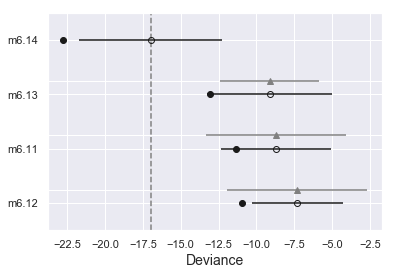

In [24]:
# Code 6.25

pm.compareplot(compare_df);

* closed: in-sample waic
* open: (out-of-sample) waic
* dark line: waic se
* triangle: diff between best and current
* grey line: se of diff between best and current

overlap in se of waic is not same as se of difference between models b/c uncertainty about models is correlated between models

akaike weight = rescale relative predictive accuracy to sum to 1 between models

unclear, akaike's interpretation: "estimate of probability that model will make best predictions on new data, conditional on st of models considered"

only 12 cases, thus lots of uncertainty around waic.

using uncertainty around differences, chance of difference being negative thus other model actualy being best:

In [25]:
# Code 6.26

diff = np.random.normal(loc=6.7, scale=7.26, size=100000)

# this is in the pymc3 implementation and i think it's wrong. summing up actual values. 
# sum(diff[diff<0]) / 100000
# out: ~ -0.7

# instead want to count how often< 0 event happens.
# this also matches the output of the book
sum(diff<0) / 100000

0.17842

**rethining: how big a difference in waic is "significant"?** hard to say what 'significance' means in this case. models won't make same predictions. also, no established values like '5%'. book's stance: keep and present all models, to give most wholistic picture and enable best discussion.

**rethinking: waic metaphors.** 

1: waic scores = race horses. best horse most likely to win. also, if one horse wins by large margin then high confidence it's actually best horse. however, for small margin: less certain. also, hard to say how things play out when environment changes - how will model perform for new data, possibly from different process?

2: waic scores = stones thrown to skip on a lake. for each throw lots of things can change: bad grip, good wind etc. good stone will go farther on average. the bigger the differences between stones are the more certain we can be that stone is actually better.

#### 6.4.1.2. comparing estimates

comparing estimates can help understand *why* one model is better/worse than another. also, can help to understand if parameter stays important across models when adding/removing other parameters.

In [26]:
# Code 6.27

coeftab = pd.DataFrame({'m6_11': pm.summary(trace_m6_11)['mean'],
                        'm6_12': pm.summary(trace_m6_12)['mean'],
                        'm6_13': pm.summary(trace_m6_13)['mean'],
                        'm6_14': pm.summary(trace_m6_14)['mean']})
coeftab

,m6_11,m6_12,m6_13,m6_14
alpha,0.656214,0.382447,0.702646,-1.073473
beta,NaN,0.407812,-0.030599,NaN
beta__0,NaN,NaN,NaN,-0.095901
beta__1,NaN,NaN,NaN,2.774015
sigma,0.189286,0.195654,0.181992,0.141962


**note: harder to read b/c pymc3 calls parameters 'beta[0]', 'beta[1]' instead of 'bn', 'bm'.**

change in uncertainty around estimates also important, plot to see better

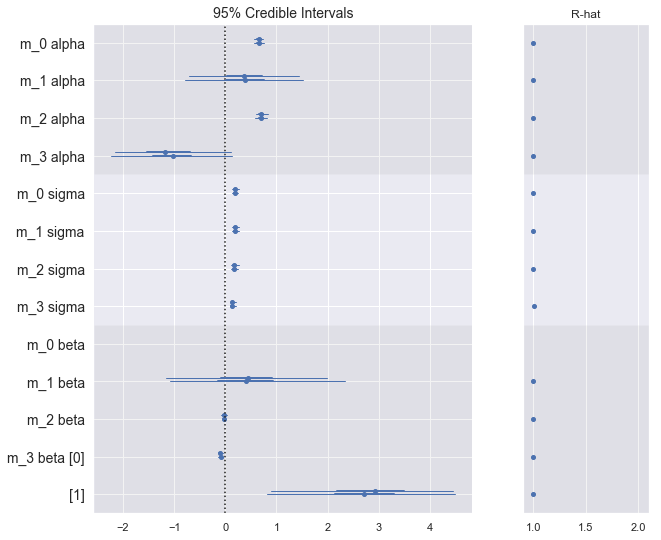

In [27]:
# Code 6.28

traces = [trace_m6_11, trace_m6_12, trace_m6_13, trace_m6_14]   
models = [m6_11, m6_12, m6_13, m6_14]

plt.figure(figsize=(10, 8))
pm.forestplot(traces, plot_kwargs={'fontsize':14});

**note: why are there multiple points per parameter per model? and again, having different parameter naming conventions would have made things easier**

**rethinking: barlots suck.** McElreath: bars carry little information but clutter visuals a lot. use dotcharts instead.

### 6.5.2. model averaging

posterior predictive for *single* model:

In [28]:
# Code 6.29

kcal_per_g = np.repeat(0, 30) # empty outcome
neocortex = np.linspace(0.5, 0.8, 30) # sequence of neocortex
mass = np.repeat(4.5, 30)     # average mass

mass_shared.set_value(np.log(mass))
neocortex_shared.set_value(neocortex)
post_pred = pm.sample_ppc(trace_m6_14, samples=10000, model=m6_14)

100%|██████████| 10000/10000 [00:10<00:00, 957.30it/s]


posterior predictive averaged for *all* models:

In [29]:
# Code 6.30
milk_ensemble = pm.sample_ppc_w(
    traces, 
    10000, 
    models, 
    weights=compare_df.weight.sort_index(ascending=True)
)

100%|██████████| 10000/10000 [00:10<00:00, 976.09it/s]


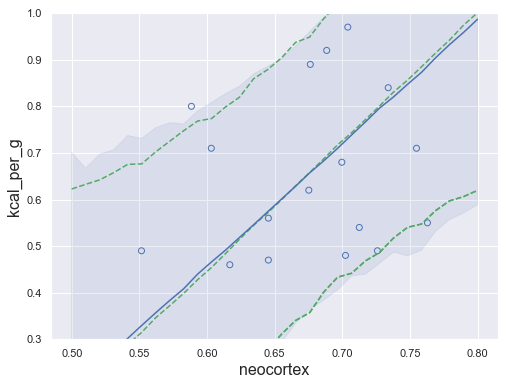

In [30]:
plt.figure(figsize=(8, 6))

plt.plot(neocortex, post_pred['kcal'].mean(0), ls='--', color='C2')
hpd_post_pred = pm.hpd(post_pred['kcal'])
plt.plot(neocortex,hpd_post_pred[:,0], ls='--', color='C2')
plt.plot(neocortex,hpd_post_pred[:,], ls='--', color='C2')

plt.plot(neocortex, milk_ensemble['kcal'].mean(0), color='C0')
hpd_av = pm.hpd(milk_ensemble['kcal'])
plt.fill_between(neocortex, hpd_av[:,0], hpd_av[:,1], alpha=0.1, color='C0')

plt.scatter(d['neocortex'], d['kcal_per_g'], facecolor='None', edgecolors='C0')

plt.ylim(0.3, 1)
plt.xlabel('neocortex', fontsize=16)
plt.ylabel('kcal_per_g', fontsize=16);


**note: this looks very different from the book (it does look the same as in the pmc3 reference). compare and discuss**

mechanics for averaging v simple: get posterior predictive samples from each model, weigh those by akaike model weight, use all these weighted samples as the predictive posterior for ensemble

model averaging: sometimes little influence on predictions. sometimes massive. but always conservative approach that protects about overconfidence in single model. will never make predictor more influential than it is in any single model.

**rethinking: the curse of tippecanoe.** if exhaustively trying to all possible models will find some that fit really well. all big enough datasets have meaningless patterns of strong correlations in them, e.g. presidential names, election dates and facts about their life. patterns not actually based on real mechanisms will not generalize to new data.

however, there are valid use-cases for just trying lots of models.

1: explore data if there is no clear hypothesis. make sure to communicate that this is happening. use findings to inform future investigations.

2: demonstrate that no (combination of) predictors is useful for predicting outcome.

## 6.6. summary

Chapter flow: overfitting -> regularization and information criteria.

Regularizing priors: reduce overfit during estimation.

Information criteria: help estimate degree of overfitting.

Introduced model comparison and ensembles based on information criteria.

*All tools just heuristics, no guarantees. "No statistical procedure will ver substitue for iterative scientific investigation."*

## 6.7. practice

**Easy**

**6E1**

*"State the three motivating criteria that define information entropy. Try to express each in your
own words"*

We want to have some measure of uncertainty. We want that measure to have the following properties:

* small changes in underlying probabilities should result in small changes in uncertainty (continuous measure)
* if nr of events increases, uncertainty should increase - it's harder to say what's going to happen if there are more choices. but actually, not obvious. assume that probabilities of all events need to sum to 1. then adding new event means taking away probability from some event(s) and assigning it to new event. thus: changing probabilities. could also change probabilities in such a way to resulting final distribution has less entropy than before, by probability being way more focused on one event? also, what happens to entropy if probabilities are uniform, then new event gets added and probabilities are spread out evenly again? (probably increases) **discuss**
* additive: uncertainty about (A or B) and uncertainty about (X or Y) should be equal to uncertainty about (A and X, or A and Y, or B and X, or B and Y). However, shouldn't that take into account correlations between those and thus use whole joint distribution instead of marginals? **discuss**

In [2]:
def inf_ent(probabilities):
    return - np.sum(np.array(probabilities) * np.log(probabilities))

**6E2**

*"Suppose a coin is weighted such that, when it is tossed and lands on a table, it comes up heads 70% of the time. What is the entropy of this coin?"*

Copy from above, formula of information entropy:

$$
H(p) = -E \log (p_i) = - \sum_{i=1}^n p_i \log (p_i)
$$

For this coin we have two events, heads and tails, with two respective probabilities: 0.7 and 0.3. Plugging these in:

In [3]:
inf_ent([0.3, 0.7])

0.6108643020548935

$$
H(\text{coin}) = - (0.7 * \log(0.7) + 0.3 * \log(0.3)) = 0.61
$$

How can this be under the interpretion of 'entropy = avg number of questions needed to determine state of system'? Shouldn't this always be greater than 1, except for systems with only a single state? **discuss**

**6E3**

*"Suppose a four-sided die is loaded such that, when tossed onto a table, it shows “1” 20%, “2” 25%, ”3” 25%, and ”4” 30% of the time. What is the entropy of this die?"*

In [4]:
inf_ent([.2, .25, .25, .3])

1.3762266043445461

**6E4**

*"Suppose another four-sided die is loaded such that it never shows “4”. The other three sides show equally often. What is the entropy of this die?"*

In [5]:
inf_ent([.3, .3, .3, 0])

nan

How to handle 0 probabilty? Define that 

$$
0 \log(0) = 0
$$

matching intuition that events that never happen do not influence uncertainty. Incorporating that into my inf_ent function:

In [6]:
def inf_ent(probabilities):
    """
    Information entropy that drops out 0-probability events
    """
    
    probabilities = np.asarray(probabilities)
    probabilities = probabilities[probabilities.nonzero()]
    
    return - np.sum(probabilities * np.log(probabilities))

In [7]:
inf_ent([.3, .3, .3, 0])

1.0835755238933424

**Medium**

**6M1**

*"Write down and compare the definitions of AIC, DIC, and WAIC. Which of these criteria is most general? Which assumptions are required to transform a more general criterion into a less general one?"*

$$
\text{AIC} = D_{\text{train}} + 2p
$$

$$
\text{DIC} = \bar D + (\bar D - \hat D) = \bar D + p_D
$$

$$
\text{WAIC} = -2(\text{lppd} - p_{waic})
$$

Not sure how to compare these definitions. Regarding assumptions:

To go from more general to less general: add assumptions.

From WAIC to DIC: add assumption that posteriors are multivariate Gaussians.

From DIC to AIC: add assumption that priors are flat.

This makes WAIC the most general and AIC the least general criterion.

**6M2**

*"Explain the difference between model selection and model averaging. What information is lost under model selection? What information is lost under model averaging?"*

Model selection = pick single best model according to some criterion. Discard others. Information lost: relative confidence in model as compared to other models. Contributions of other models.

Model averaging = average predictions based on relative accuracy of individual models. Discard none. Information lost: none?

**6M3**

*"When comparing models with an information criterion, why must all models be fit to exactly the same observations? What would happen to the information criterion values, if the models were fit to different numbers of observations? Perform some experiments, if you are not sure."*

Higher number of observations -> higher (worse) value for IC. Unfair comparison

**6M4**

*"Whathappenstotheeffectivenumberofparameters,asmeasuredbyDICorWAIC,asaprior becomes more concentrated? Why? Perform some experiments, if you are not sure."*

Guess: nr of effective params reduces when prior becomes more informative. **Unsure, follow-up here.**

**6M5**

*"Provide an informal explanation of why informative priors reduce overfitting."*

Make models pay less attention to data, thus less likely to learn from non-generalizable features. Pushes posteriors towards value regions that are deemed more likely a-priori. Posterior will look a bit more like prior, a bit less like data.

**6M6**

*"Provide an information explanation of why overly informative priors result in underfitting."*

Model will learn too little from data/pay too little attention to it. Will actually not learn generalizable patterns. Posterior will look a lot like prior, with little impact of data.

**Hard**

In [8]:
import math

In [9]:
# Code 6.31

d = (
    pd
    .read_csv('./data/Howell1.csv', sep=';')
    .assign(age = lambda df: (df.age - df.age.mean()) / df.age.std())
)

rs = np.random.RandomState(42)
ix = rs.choice(np.asarray(range(len(d))), size=math.floor(len(d)/2), replace=False)

d1 = d.iloc[ix].sort_index()
d2 = d.iloc[d.index.difference(ix)]

print(d1.shape)
print(d2.shape)

(272, 4)
(272, 4)


In [10]:
age_shared = theano.shared(d1.age.values)

In [11]:
def poly_model(n):
    """
    Fit polynomial model between age and height of degree n.
    
    return:
        model, trace
    """
    coeff_range = range(1, n+1)
    
    with pm.Model() as m:
        betas = [pm.Normal('beta_{}'.format(coeff), mu=0, sd=20) for coeff in coeff_range]
        age_transforms = [age_shared ** coeff for coeff in coeff_range]
        beta_x_age = sum([beta * age_transform for beta, age_transform in zip(betas, age_transforms)])
        
        a = pm.Normal('a', mu=d1.height.mean())
        mu = pm.Deterministic('mu', a + beta_x_age)
        sigma = pm.Uniform('sigma', lower=0, upper=50)
        height = pm.Normal('height', mu=mu, sd=sigma, observed=d1.height)

        trace = pm.sample(2000, tune=5000)
        
        return (m, trace)

In [12]:
poly_values = list(range(1, 7))

In [13]:
models_and_traces = [poly_model(n) for n in poly_values]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, beta_1]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:26<00:00, 525.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, beta_2, beta_1]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:18<00:00, 750.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, beta_3, beta_2, beta_1]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:26<00:00, 521.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, beta_4, beta_3, beta_2, beta_1]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:40<00:00, 348.94draws/s]
The number of effective samples is smaller than 25% for some paramet

**note: what are weakly regularizing priors in this case? what kind of value ranges are expected?**

**note 2: should i worried about warnings such as "There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5799279328315171, but should be close to 0.8. Try to increase the number of tuning steps." ?**

In [14]:
pm.summary(models_and_traces[5][1]).loc[lambda df: ~ df.index.str.contains('__')]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_1,4.660998,2.865852,0.077631,-1.109653,10.237304,1356.432391,1.000215
beta_2,4.166041,2.676173,0.066879,-1.203303,9.188577,1520.483577,1.001181
beta_3,13.217950,4.526474,0.129143,4.965674,22.765572,1189.783740,1.000427
beta_4,-12.614217,1.707452,0.045672,-15.997123,-9.400788,1439.937897,1.000048
beta_5,0.579664,1.662815,0.046179,-2.528135,3.922785,1241.585706,1.000643
beta_6,0.823389,0.564796,0.015901,-0.210007,1.980099,1262.473149,1.000099
a,145.116411,0.926204,0.021600,143.241376,146.921491,1680.891560,1.001734
sigma,9.917976,0.511681,0.010701,8.906727,10.889334,1995.272243,1.000517


**6H1**

In [15]:
compare_df = (
    pm
    .compare(
        model_dict = {m: t for m, t in models_and_traces},
        method='pseudo-BMA'
    )
    .assign(model = ['m{}'.format(poly) for poly in poly_values])
    .set_index('model')
)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [16]:
compare_df.sort_values('WAIC')

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m1,2024.42,6.03,0,0.6,25.06,0,1
m2,2025.43,4.91,1.01,0.36,25.77,2.86,0
m3,2030.41,5.53,5.98,0.03,24.02,8.61,1
m4,2099.29,4.35,74.87,0,23.85,16.66,1
m5,2208.94,3.05,184.52,0,23.34,19.93,0
m6,2421.28,2.66,396.85,0,21.71,26.25,0


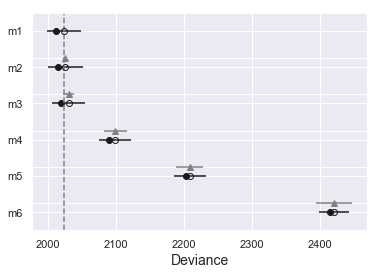

In [17]:
pm.compareplot(compare_df);

Comparison: 1-poly model has best WAIC, gets half of total weight. Nearly all of other weight goes to 2-poly model, others are essentially 0.

Higher order model: worse (higher) WAIC, less weight.

**6H2**

In [18]:
sns.set()

In [19]:
def plot_trace_dataframe(t_df, ax, title):
    """
    Plot trace dataframe t_df into axes ax
    """

    means = t_df.mean()

    mu_hpd = pm.hpd(t_df.filter(like='mu__').values, alpha=0.03)

    xy = (
        pd
        .DataFrame(
            data=means.filter(like='mu__'), 
            columns=['mu']
        )
        .assign(
            age=d1.age.values,
            height=d1.height.values,
            mu_hpd_lower=mu_hpd[:,0],
            mu_hpd_upper=mu_hpd[:,1]
        )
        .sort_values('age')
        .reset_index(drop=True)
    )

    ax.plot('age', 'mu', 'g-', data=xy)
    ax.plot('age', 'height', 'ob', mew=1, fillstyle='none', alpha=.3, data=xy)
    ax.fill_between('age', 'mu_hpd_lower', 'mu_hpd_upper', color='g', alpha=.3, data=xy)
    ax.set_xlabel('standardized age')
    ax.set_ylabel('height')
    ax.set_title(title)

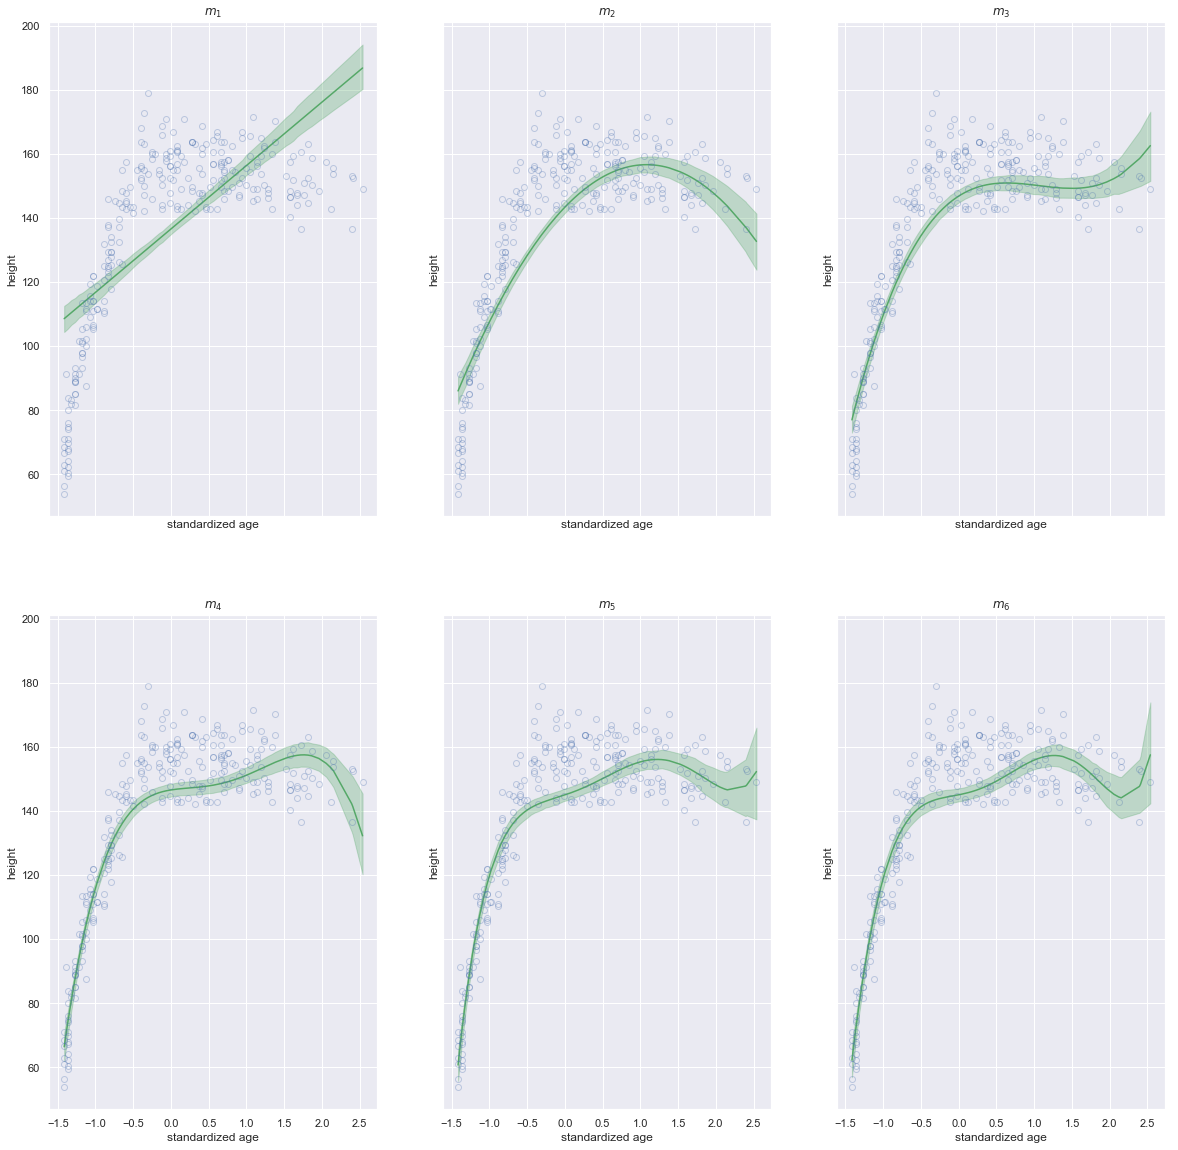

In [20]:
figure, axes_array = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, squeeze=False, figsize=(20, 20))

for ((_, t), ax, i) in zip(models_and_traces, axes_array.ravel(), range(len(models_and_traces))):
    plot_trace_dataframe(pm.trace_to_dataframe(t), ax, '$m_{}$'.format(i+1))

Analysis:

The higher the degree of the polynomial the closer the means follow the data. However, where the change from degree 1 (line) to degree 2 (parabola) seems to create predicted means that follow the global trend of the data, going to higher degrees leads to predictions that become unstable, 'squiggly' and follow minor variations in the data which probably won't generalize.

**6H3**

In [21]:
height_ensemble = pm.sample_ppc_w(
    [trace for (model, trace) in models_and_traces], 
    10000, 
    [model for (model, trace) in models_and_traces], 
    weights=compare_df.weight.sort_index(ascending=True)
)

100%|██████████| 10000/10000 [00:10<00:00, 989.42it/s]


In [22]:
height_ensemble['height'].shape

(10000, 272)

In [23]:
# NOTE: values aren't actually 'mu' values, but 'height' values, my function just expects that naming
height_ensemble_df = pd.DataFrame(data=height_ensemble['height'], columns=['mu__{}'.format(i) for i in range(272)])

In [24]:
height_ensemble_df.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__262,mu__263,mu__264,mu__265,mu__266,mu__267,mu__268,mu__269,mu__270,mu__271
0,152.615995,140.209965,161.386627,156.622551,122.256632,156.238450,146.927707,122.150614,187.716032,161.072529,...,132.252947,93.984997,162.766372,167.644447,146.284884,109.409253,146.513629,156.909575,128.802367,193.725534
1,184.393438,156.350705,128.749526,138.927553,128.394939,134.167741,142.915937,201.797868,170.818583,151.901981,...,121.007275,89.708606,134.732859,187.407264,105.571323,109.658799,99.930595,166.008859,110.303200,190.869818
2,202.708863,149.051210,139.667659,122.579260,143.920771,131.732527,179.214845,154.775469,175.004384,148.957776,...,121.754146,164.921224,134.314445,190.131971,119.898741,129.526812,148.098925,115.558081,111.069767,185.906413
3,156.609145,156.839435,147.550602,181.324788,157.841598,149.424708,161.793417,166.615004,140.316687,148.441952,...,139.267834,105.316534,163.993301,159.329248,108.384825,148.748212,119.538602,134.717265,65.953795,167.119713
4,166.060835,148.613417,153.254191,136.183548,149.838019,125.734561,155.756387,183.462394,146.242353,184.654111,...,126.913781,108.461207,156.963384,170.829607,115.687006,119.723182,155.021588,136.904183,173.042530,171.186659


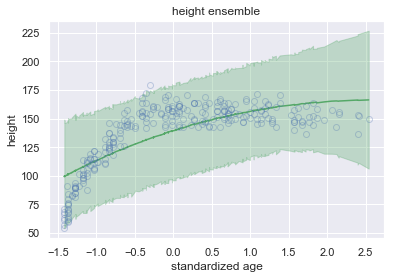

In [25]:
plot_trace_dataframe(height_ensemble_df, plt.axes(), 'height ensemble')

the above only gives me the posterior predictive, not exactly what i am looking for. the book seems to request to specifically compare differences in predicted means/spread of mean

idea: create weighted average of samples per model, treat that as sample of new model

In [26]:
weights=compare_df.weight.sort_index(ascending=True)

In [27]:
weights

model
m1     0.6
m2    0.36
m3    0.03
m4       0
m5       0
m6       0
Name: weight, dtype: object

how to deal with cases of 0 weight? will add nothing to sample but will increase denominator in (weighted_sum) / (number_of_models). this will change scale of parameter estimation, probably unwanted

In [28]:
weights[weights > 0]

model
m1     0.6
m2    0.36
m3    0.03
Name: weight, dtype: object

In [29]:
sum(weights > 0)

3

In [30]:
weighted_average_df = sum([weight * pm.trace_to_dataframe(t) for (weight, (_, t)) in zip(weights, models_and_traces)])

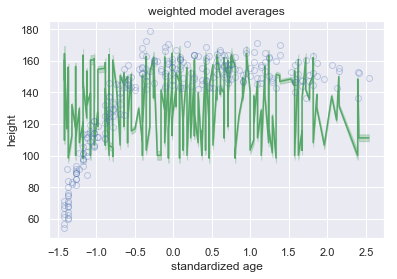

In [31]:
plot_trace_dataframe(weighted_average_df, plt.axes(), 'weighted model averages')

not what i want - i don't want to average samples, i want to mix complete samples in relative amounts proportional to model weight. let's try again

In [32]:
# 4k samples = same amount as single model samples
n_ensemble_samples = 10000

In [33]:
trace_dfs_with_weights = [
    pm.trace_to_dataframe(trace).assign(ensemble_weight=weight, model='m{}'.format(i))
    for (weight, (_, trace), i) in zip(weights, models_and_traces, range(1, len(models_and_traces)+1))
]
    

In [34]:
trace_dfs_with_weights[0].shape

(4000, 277)

In [35]:
for i, df in enumerate(trace_dfs_with_weights[:1]):
    print(i)
    print(df.mean())

0
beta_1              19.795588
a                  136.630066
mu__0              168.742472
mu__1              170.650767
mu__2              147.751231
mu__3              142.026348
mu__4              139.163906
mu__5              134.393169
mu__6              160.155146
mu__7              153.476115
mu__8              171.604914
mu__9              142.980495
mu__10             150.613673
mu__11             138.209758
mu__12             120.080960
mu__13             116.264370
mu__14             136.301464
mu__15             121.035107
mu__16             115.310223
mu__17             162.063441
mu__18             151.567821
mu__19             123.897549
mu__20             119.126812
mu__21             136.301464
mu__22             131.530727
mu__23             134.393169
mu__24             139.163906
mu__25             131.530727
mu__26             158.246852
mu__27             124.851696
                      ...    
mu__244            111.493634
mu__245            170.650767
mu__246 

In [36]:
weighted_samples = pd.concat(trace_dfs_with_weights, ignore_index=True)

In [37]:
weighted_samples.shape

(24000, 282)

In [38]:
weighted_samples.head()

,a,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,ensemble_weight,model,mu__0,...,mu__91,mu__92,mu__93,mu__94,mu__95,mu__96,mu__97,mu__98,mu__99,sigma
0,137.257170,19.091368,NaN,NaN,NaN,NaN,NaN,0.6,m1,168.227192,...,130.498831,129.578627,182.950455,147.062502,169.147396,139.700870,168.227192,167.306988,130.498831,20.613204
1,137.391463,19.313070,NaN,NaN,NaN,NaN,NaN,0.6,m1,168.721129,...,130.554641,129.623751,183.615369,147.310660,169.652019,139.863540,168.721129,167.790239,130.554641,19.525633
2,137.302006,21.364447,NaN,NaN,NaN,NaN,NaN,0.6,m1,171.959416,...,129.738997,128.709231,188.435677,148.274791,172.989182,140.036660,171.959416,170.929650,129.738997,21.369514
3,136.185985,22.512989,NaN,NaN,NaN,NaN,NaN,0.6,m1,172.706560,...,128.216392,127.131266,190.068577,147.748661,173.791686,139.067653,172.706560,171.621434,128.216392,21.451570
4,136.607549,18.016885,NaN,NaN,NaN,NaN,NaN,0.6,m1,165.834543,...,130.229577,129.361163,179.729165,145.861025,166.702957,138.913715,165.834543,164.966130,130.229577,19.704537


In [39]:
weighted_ensemble_samples = weighted_samples.sample(
    n=n_ensemble_samples, 
    replace=True, 
    weights=weighted_samples.ensemble_weight,
    random_state=np.random.RandomState(42)
)

In [40]:
weighted_ensemble_samples.shape

(10000, 282)

In [41]:
weighted_ensemble_samples.head()

,a,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,ensemble_weight,model,mu__0,...,mu__91,mu__92,mu__93,mu__94,mu__95,mu__96,mu__97,mu__98,mu__99,sigma
2471,136.593478,20.473279,NaN,NaN,NaN,NaN,NaN,0.60,m1,169.805235,...,129.345942,128.359130,185.594227,147.108558,170.792047,139.214062,169.805235,168.818423,129.345942,21.931629
7791,143.107550,23.884898,-11.273611,NaN,NaN,NaN,NaN,0.36,m2,152.186752,...,133.239540,131.677378,135.694318,152.401028,151.548844,145.980115,152.186752,152.772277,133.239540,13.859728
5385,142.309030,24.133005,-10.220133,NaN,NaN,NaN,NaN,0.36,m2,154.562975,...,132.485208,130.949485,141.524324,152.007828,154.104216,145.230613,154.562975,154.974245,132.485208,13.918459
3951,135.719803,19.691851,NaN,NaN,NaN,NaN,NaN,0.60,m1,167.663929,...,128.748892,127.799745,182.850284,145.833542,168.613076,138.240365,167.663929,166.714781,128.748892,19.580404
1029,137.226686,20.896436,NaN,NaN,NaN,NaN,NaN,0.60,m1,171.124889,...,129.829352,128.822144,187.240220,147.959100,172.132097,139.901434,171.124889,170.117681,129.829352,19.861874


sanity check: models should contribute proportional to their weight

In [42]:
(
    pd
    .concat(
        objs=[
            (weighted_ensemble_samples.model.value_counts() / len(weighted_ensemble_samples)).rename('sampled_fraction'),
            weights.rename('ensemble_weight')
        ],
        axis=1
    )
    .fillna(0)
    .assign(difference=lambda df: df.ensemble_weight - df.sampled_fraction)
)

,sampled_fraction,ensemble_weight,difference
m1,0.6171,0.60,-0.0171
m2,0.3557,0.36,0.0043
m3,0.0272,0.03,0.0028
m4,0.0000,0.00,0.0000
m5,0.0000,0.00,0.0000
m6,0.0000,0.00,0.0000


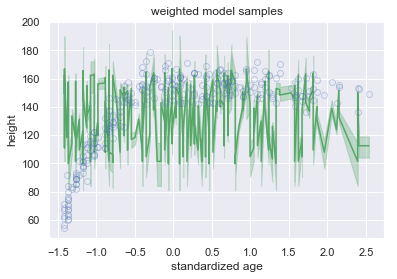

In [43]:
plot_trace_dataframe(weighted_ensemble_samples, plt.axes(), 'weighted model samples')

why is this weird?

Text(0.5, 1.0, 'debug')

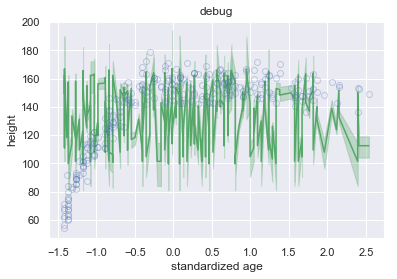

In [44]:
t_df = weighted_ensemble_samples
ax = plt.axes()
title = 'debug'

means = t_df.mean()

mu_hpd = pm.hpd(t_df.filter(like='mu__').values, alpha=0.03)

xy = (
    pd
    .DataFrame(
        data=means.filter(like='mu__'), 
        columns=['mu']
    )
    .assign(
        age=d1.age.values,
        height=d1.height.values,
        mu_hpd_lower=mu_hpd[:,0],
        mu_hpd_upper=mu_hpd[:,1]
    )
    .sort_values('age')
    .reset_index(drop=True)
)

ax.plot('age', 'mu', 'g-', data=xy)
ax.plot('age', 'height', 'ob', mew=1, fillstyle='none', alpha=.3, data=xy)
ax.fill_between('age', 'mu_hpd_lower', 'mu_hpd_upper', color='g', alpha=.3, data=xy)
ax.set_xlabel('standardized age')
ax.set_ylabel('height')
ax.set_title(title)

In [45]:
xy

,mu,age,height,mu_hpd_lower,mu_hpd_upper
0,149.107969,-1.41440,56.5150,144.911800,154.638066
1,158.577882,-1.41440,60.9600,153.394707,164.460128
2,110.947856,-1.41440,53.9750,101.676945,118.252932
3,152.921880,-1.41440,62.8650,149.312860,157.346822
4,147.444436,-1.41440,68.5800,142.976993,153.138327
5,166.670202,-1.41440,66.6750,131.094768,189.875583
6,162.348950,-1.41440,71.1200,149.952919,172.193071
7,118.254639,-1.38548,91.4400,113.193942,122.514564
8,151.454959,-1.36620,80.0100,147.663126,156.452422
9,149.909977,-1.36620,67.3100,145.843627,155.295300


okay, still weird. let's try the 'official' pymc3 functions:

In [46]:
model, trace = models_and_traces[0]

In [47]:
model.mu

mu

In [48]:
post_sample = pm.sample_ppc(trace, samples=4000, model=model, vars=[model.mu])

100%|██████████| 4000/4000 [00:00<00:00, 7146.28it/s]


In [49]:
post_sample['mu'].shape

(4000, 272)

In [50]:
post_sample_df = pd.DataFrame(data=post_sample['mu'], columns=['mu__{}'.format(i) for i in range(272)])

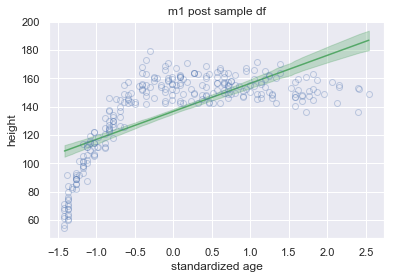

In [51]:
plot_trace_dataframe(post_sample_df, plt.axes(), 'm1 post sample df')

looks promising

In [52]:
post_sample_dfs = [
    pd.DataFrame(
        data=pm.sample_ppc(trace, samples=int(weight*4000), model=model, vars=[model.mu])['mu'], 
        columns=['mu__{}'.format(i) for i in range(len(d1))]
    ).assign(model='m{}'.format(m_i))
    for (weight, (model, trace), m_i) in zip(weights, models_and_traces, range(1, len(models_and_traces))) if weight > 0
]

100%|██████████| 120/120 [00:00<00:00, 1602.41it/s]


In [53]:
[_.shape for _ in post_sample_dfs]

[(2400, 273), (1440, 273), (120, 273)]

In [54]:
post_sample_combined = pd.concat(post_sample_dfs, ignore_index=True)

In [55]:
post_sample_combined.model.value_counts() / len(post_sample_combined)

m1    0.606061
m2    0.363636
m3    0.030303
Name: model, dtype: float64

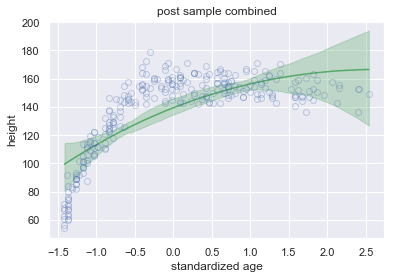

In [56]:
plot_trace_dataframe(post_sample_combined, plt.axes(), 'post sample combined')

that looks more plausible :)

now to the actual question: "in what ways do the averaged predictions differ from the predictions of the model with the lowest WAIC value?" let's compare side by side


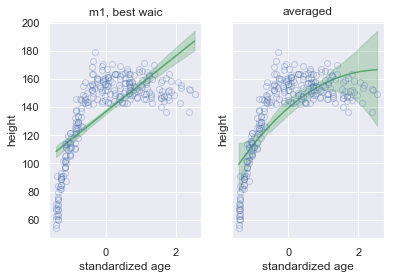

In [57]:
figure, axes_array = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, squeeze=False)

lowest_waic_trace_df = pm.trace_to_dataframe(models_and_traces[0][1])

plot_trace_dataframe(lowest_waic_trace_df, axes_array.ravel()[0], 'm1, best waic')
plot_trace_dataframe(post_sample_combined, axes_array.ravel()[1], 'averaged')

averaged model has more uncertainty. averaged model is curve formed from combining straight line (m1) and parabola (m2). follow curvature of data better than best model.

**6H4**

In [58]:
age_shared.set_value(d2.age)

In [59]:
m, t = models_and_traces[0]

14239.612246047385
[12923.81759154 15114.14691976]
27047.28243005478
[23719.77519808 29060.70823742]
40525.870256019116
[34523.8601547  43981.98823906]
52209.59996253929
[46307.75266783 57925.12480056]
54156.522036768125
[47335.22766809 58649.21777135]
54481.0775579208
[47981.64351847 58922.94271003]


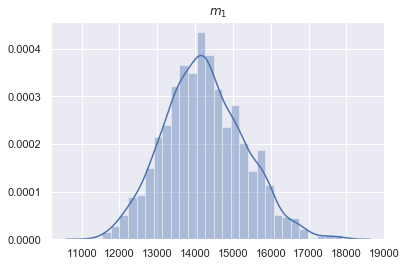

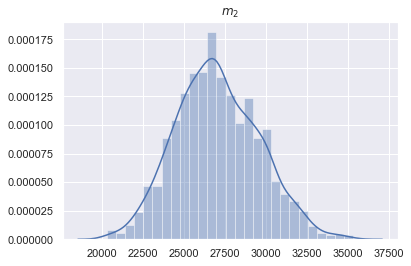

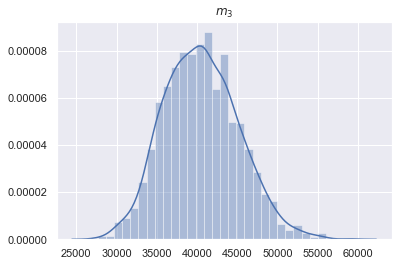

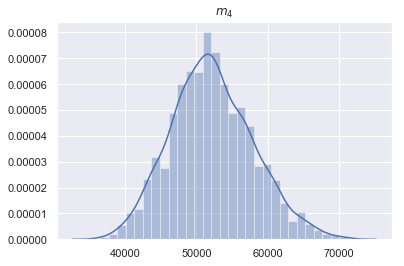

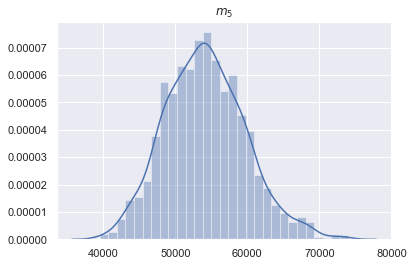

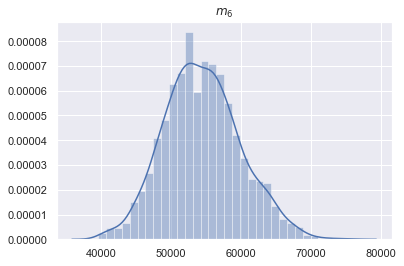

<Figure size 432x288 with 0 Axes>

In [60]:
mean_deviances = list()

for (i, (m, t)) in enumerate(models_and_traces):
    
    test_samples = pm.sample_ppc(t, model=m, vars=[m.mu, m.sigma], progressbar=False)

    dev = -2 * np.sum(
        stats.norm.logpdf(
            x = d2.age, 
            loc = test_samples['mu'], 
            scale = test_samples['sigma'][:, np.newaxis]
        ),
        axis=1
    )

    mean_deviances.append(dev.mean())


    # this is one deviance value per set of sampled parameters. 
    # as there is uncertainty around parameters there is uncertainty around deviance. let's have a look:

    print(dev.mean())
    print(pm.hpd(dev, alpha=0.3))
    sns.distplot(dev);
    plt.title(f'$m_{i+1}$');
    plt.figure();

## 6H5

In [61]:
mean_deviances =  np.asarray(mean_deviances)
mean_deviances

array([14239.61224605, 27047.28243005, 40525.87025602, 52209.59996254,
       54156.52203677, 54481.07755792])

In [62]:
norm_deviances = mean_deviances - mean_deviances.min()

In [63]:
norm_waic = compare_df.WAIC - compare_df.WAIC.min()

In [64]:
deviance_vs_waic = (
    pd
    .DataFrame(
        data=zip(norm_deviances, norm_waic), 
        columns=['deviance', 'waic'], 
        index=[f'm_{i}' for i in range(1, 7)]
    )
)
deviance_vs_waic

,deviance,waic
m_1,0.000000,0.00
m_2,12807.670184,1.01
m_3,26286.258010,5.99
m_4,37969.987716,74.87
m_5,39916.909791,184.52
m_6,40241.465312,396.86


In [65]:
deviance_vs_waic.corr()

,deviance,waic
deviance,1.000000,0.683628
waic,0.683628,1.000000


Deviance and WAIC have a positive correlation. Models with higher test set deviance also tend to have a higher WAIC. The relationship does seem to be non-linear. Also, Deviance and WAIC are on different scales. Then again, they're only meaningful as relative measures anyway, so that would not be an issue.

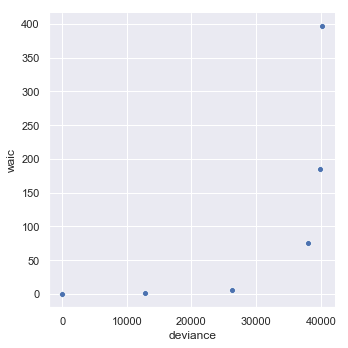

In [66]:
sns.relplot(x='deviance', y='waic', data=deviance_vs_waic)

## 6H6

In [68]:
shared = theano.shared(d1.age.values, 'age')

In [69]:
with pm.Model() as m:
    coeff_range = range(1, 7)
    
    betas = [pm.Normal('beta_{}'.format(coeff), mu=0, sd=5) for coeff in coeff_range]
    age_transforms = [shared ** coeff for coeff in coeff_range]
    beta_x_age = sum([beta * age_transform for beta, age_transform in zip(betas, age_transforms)])

    a = pm.Normal('a', mu=d1.height.mean())
    mu = pm.Deterministic('mu', a + beta_x_age)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d1.height)

In [70]:
reg_model = therapy.Model(m, {'age': shared}, 'regularized_model')

fit to data in d1

In [71]:
reg_model.fit(d1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, beta_6, beta_5, beta_4, beta_3, beta_2, beta_1]


In [74]:
trace_df = pm.trace_to_dataframe(reg_model.trace)
trace_df.head()

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,a,mu__0,mu__1,mu__2,...,mu__263,mu__264,mu__265,mu__266,mu__267,mu__268,mu__269,mu__270,mu__271,sigma
0,4.956748,3.091090,11.306054,-12.029272,1.392073,0.562423,146.500259,153.524496,151.961325,151.162589,...,108.078387,156.517017,155.362995,71.790834,146.920756,140.677231,146.920756,62.162834,149.413457,9.571921
1,5.250293,3.754245,12.061218,-12.651546,1.293076,0.633834,146.002540,154.351801,152.687280,151.107706,...,106.340187,157.249934,155.855521,68.971819,146.451042,140.013114,146.451042,59.081525,149.914749,9.301743
2,4.340465,1.426233,13.930628,-10.974541,-0.075765,0.861255,145.096122,154.203943,152.797498,149.384457,...,106.465507,155.746851,154.057969,74.032514,145.458209,138.752444,145.458209,65.795934,150.311612,10.270110
3,4.068141,1.549720,15.783490,-11.321801,-0.814401,1.105550,144.537741,155.187855,153.732132,148.972350,...,105.001696,156.311481,154.261140,73.246207,144.879807,138.031916,144.879807,65.374243,151.109048,10.377549
4,6.311046,1.506163,13.730940,-11.793543,-0.136694,1.017561,146.529409,154.684172,152.809072,151.834554,...,105.181455,158.076701,156.666832,71.885107,147.049122,138.992426,147.049122,63.485544,149.703394,10.288120


inspect MAP values (sort of)

In [85]:
pm.summary(reg_model.trace, ['beta_{}'.format(i) for i in range(1, 7)] + ['a', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_1,7.133941,2.069475,0.065604,3.124632,11.227599,851.731019,1.000068
beta_2,2.109499,2.198021,0.081810,-2.204660,6.126782,718.892889,0.999744
beta_3,8.469881,3.101427,0.113446,2.446571,14.600737,672.113146,1.000283
beta_4,-10.511781,1.363157,0.051266,-13.116784,-7.788249,651.180435,1.000418
beta_5,2.250440,1.192955,0.042648,-0.173643,4.572013,729.167863,1.000089
beta_6,0.135405,0.413867,0.015300,-0.746454,0.914716,685.675326,1.000381
a,145.370953,0.889645,0.027542,143.519350,147.124066,1112.368464,1.000132
sigma,9.874815,0.515003,0.014288,8.912959,10.889004,1227.003148,0.999956


plot implied predictions

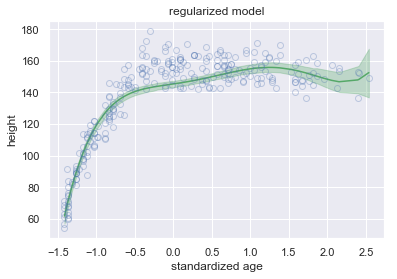

In [87]:
plt.figure()
plot_trace_dataframe(pm.trace_to_dataframe(reg_model.trace), plt.gca(), 'regularized model')

compute out of sample deviance for d2

In [88]:
dev = -2 * np.sum(
    stats.norm.logpdf(
        x = d2.age, 
        loc = test_samples['mu'], 
        scale = test_samples['sigma'][:, np.newaxis]
    ),
    axis=1
)

In [89]:
dev.mean()

54481.0775579208

compare to model w/ best waic from earlier

In [90]:
# best model as per waic: m1
best_other_m_and_t = models_and_traces[0]

In [91]:
mean_deviances[0]

14239.612246047385

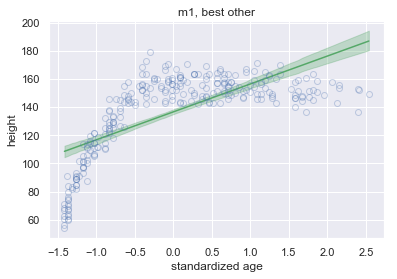

In [93]:
plt.figure()
plot_trace_dataframe(pm.trace_to_dataframe(best_other_m_and_t[1]), plt.gca(), 'm1, best other')

**note: really weird that this linear model would be so much better than any other one. hunch: exercise wants to demonstrate effect of regularization. new, regularized model should be better than best previous one**